# **Factorización Adiabatica**

In [1]:
import dimod
import numpy as np
from dwave.system import LeapHybridCQMSampler
import matplotlib.pyplot as plt
from time import time

En este cuadernillo se implementarán las estrategias expuestas en la sección 3.1 del informe. En primer lugar, trataremos de formular el CQM correspondiente para ejecutarlo en _D-Wave_. Posteriormente se realizará la digitalización en _Qiskit_.

## CQM en _D-Wave_

Comenzamos definiendo $N$ y ccreando las variables del problema. Se toma $N = 85079$.

In [2]:
N = 149*571   # N = pq, con p <= q

# Variables del problema
variables = [dimod.Integer("x"),dimod.Integer("y")]
print(variables)

[QuadraticModel({'x': 1.0}, {}, 0.0, {'x': 'INTEGER'}, dtype='float64'), QuadraticModel({'y': 1.0}, {}, 0.0, {'y': 'INTEGER'}, dtype='float64')]


Ya hemos tenido en cuenta la naturaleza entera de las variables. Establecemos a continuación los rangos de cada una de ellas.

In [3]:
# Límites para x
variables[0].set_upper_bound("x",(np.sqrt(N)-1)/2)  # Superior
variables[0].set_lower_bound("x",1)                 # Inferior

# Límites para y
variables[1].set_upper_bound("y",(N/3-1)/2)         # Superior
variables[1].set_lower_bound("y",(np.sqrt(N)-1)/2)  # Inferior

Habiendo hecho esto, podemos empezar a crear el CQM.

In [4]:
# Creamos el modelo CQM
cqm = dimod.ConstrainedQuadraticModel()

# Función objetivo
cqm.set_objective(N - (2*variables[0]+1)*(2*variables[1]+1))

# Restricción para la transformación en QUBO
cqm.add_constraint(N - (2*variables[0]+1)*(2*variables[1]+1)>=0)

# Mostramos el modelo
print(cqm)

Constrained quadratic model: 2 variables, 1 constraints, 6 biases

Objective
  85078 - 2*Integer('x') - 2*Integer('y') - 4*Integer('x')*Integer('y')

Constraints
  cc77145: 85078 - 2*Integer('x') - 2*Integer('y') - 4*Integer('x')*Integer('y') >= 0.0

Bounds
  1.0 <= Integer('x') <= 145.3415235795348
  145.3415235795348 <= Integer('y') <= 14179.333333333334



Una vez definido, solo nos queda ejecutarlo en _D-Wave_ con la ayuda de un _solver_ híbrido.

In [6]:
# Definimos el sampler híbrido
sampler = LeapHybridCQMSampler()

# Resolvemos el CQM
t0 = time()
sampleset = sampler.sample_cqm(cqm)
t1 = time()
print(f"Obtenido mínimo en {t1-t0} segundos.")

# Tomamos las soluciones factibles
feasible_sampleset = sampleset.filter(lambda row: row.is_feasible)

# Mostramos la mejor solución. Recordamos que en caso de haber factorizado N = p*q serán p = 2*x_bar + 1 = x y q = 2*y_bar + 1 = y.
best = feasible_sampleset.first.sample
x_bar, y_bar = best["x"], best["y"]
x = int(2*x_bar+1)
y = int(2*y_bar+1)
print(f"x_bar = {x_bar}. x = {x}.")
print(f"y_bar = {y_bar}. y = {y}.")
if N == x*y:
    print(f"\nFactorización correcta. {N} = {x}*{y}.")
else:
    print("\nFactorización incorrecta.")

Obtenido mínimo en 8.967328548431396 segundos.
x_bar = 74.0. x = 149.
y_bar = 285.0. y = 571.

Factorización correcta. 85079 = 149*571.


Vista la implementación adiabática, pasemos ahora a DAdQC.

## Digitalización en _Qiskit_

Recomendamos al lector que revise la notación empleada para el proceso de digitalización en el informe. Gracias a la librería _sympy_, nos es sencillo definir el Hamiltoniano de la proposición 3.1.5. En primer lugar, consideraremos el ejemplo propuesto en el artículo _Digitized Adiabatic Quantum Factorization_ referenciado en [13]. Así, tomaremos $N = 217 = 7\cdot31$, $n_x = 2$, $n_y = 4$, y _schedule_ $\lambda(t) = \sin^2\left(\frac{\pi}{2}\sin^2\left(\frac{\pi t}{2T}\right)\right)$.

In [3]:
import sympy as sp

# Parámetros iniciales
N = 7*31
ident = sp.symbols("I")  # Símbolo representando la matriz identidad

# Número de qubits. Asumimos longitudes de factores conocidas
nx = 2
ny = 4

# Definición de x e y usando Sum
l = sp.symbols('l', integer=True)
m = sp.symbols('m', integer=True)
sigma_z_l = sp.IndexedBase('σ^z')[l]
sigma_z_m = sp.IndexedBase('σ^z')[m]

x = sp.Sum(2**(l-ny) * (ident - sigma_z_l) / 2, (l, ny+1, nx+ny)).doit() + ident
y = sp.Sum(2**(m) * (ident - sigma_z_m) / 2, (m, 1, ny)).doit() + ident

# Expresiones de x e y
# print(x)
# print(y)

# Definición del Hamiltoniano según la proposición 3.1.5
Hamiltoniano = (N * ident - x * y) ** 2

El Hamiltoniano no cuenta con las propiedades de las matrices de Pauli. Necesitamos simplificar la expresión en consecuencia.

In [4]:
# Expandimos y simplificamos el Hamiltoniano con las propiedades de las matrices de Pauli
# Expansión del Hamiltoniano simplificando la identidad
Hamiltoniano_expand = sp.expand(Hamiltoniano.subs(ident, 1))

# Función para reemplazar las potencias de las matrices de Pauli
def reemp_potencia(expr):
    '''
    Devuelve la expresión resultante de reemplazar las potencias pares de las matrices de Pauli por la identidad
    y las impares por la matriz de Pauli elevada a 1.

    expr: sympy | Hamiltoniano al que queremos añadir las propiedades de las matrices de Pauli.
    '''
    if expr.is_Pow:
        base, exp = expr.args
        if exp % 2 == 0:
            return 1
        else:
            return base
    elif expr.is_Mul or expr.is_Add:
        return expr.func(*[reemp_potencia(arg) for arg in expr.args])
    else:
        return expr

# Definimos el Hamiltoniano que buscábamos
Hamiltoniano_simplificado = reemp_potencia(Hamiltoniano_expand)
print("Hamiltoniano final:\n",Hamiltoniano_simplificado)

Hamiltoniano final:
 16*σ^z[1]*σ^z[2]*σ^z[5]*σ^z[6] - 32*σ^z[1]*σ^z[2]*σ^z[5] - 64*σ^z[1]*σ^z[2]*σ^z[6] + 84*σ^z[1]*σ^z[2] + 32*σ^z[1]*σ^z[3]*σ^z[5]*σ^z[6] - 64*σ^z[1]*σ^z[3]*σ^z[5] - 128*σ^z[1]*σ^z[3]*σ^z[6] + 168*σ^z[1]*σ^z[3] + 64*σ^z[1]*σ^z[4]*σ^z[5]*σ^z[6] - 128*σ^z[1]*σ^z[4]*σ^z[5] - 256*σ^z[1]*σ^z[4]*σ^z[6] + 336*σ^z[1]*σ^z[4] - 128*σ^z[1]*σ^z[5]*σ^z[6] - 178*σ^z[1]*σ^z[5] - 356*σ^z[1]*σ^z[6] + 1064*σ^z[1] + 64*σ^z[2]*σ^z[3]*σ^z[5]*σ^z[6] - 128*σ^z[2]*σ^z[3]*σ^z[5] - 256*σ^z[2]*σ^z[3]*σ^z[6] + 336*σ^z[2]*σ^z[3] + 128*σ^z[2]*σ^z[4]*σ^z[5]*σ^z[6] - 256*σ^z[2]*σ^z[4]*σ^z[5] - 512*σ^z[2]*σ^z[4]*σ^z[6] + 672*σ^z[2]*σ^z[4] - 256*σ^z[2]*σ^z[5]*σ^z[6] - 356*σ^z[2]*σ^z[5] - 712*σ^z[2]*σ^z[6] + 2128*σ^z[2] + 256*σ^z[3]*σ^z[4]*σ^z[5]*σ^z[6] - 512*σ^z[3]*σ^z[4]*σ^z[5] - 1024*σ^z[3]*σ^z[4]*σ^z[6] + 1344*σ^z[3]*σ^z[4] - 512*σ^z[3]*σ^z[5]*σ^z[6] - 712*σ^z[3]*σ^z[5] - 1424*σ^z[3]*σ^z[6] + 4256*σ^z[3] - 1024*σ^z[4]*σ^z[5]*σ^z[6] - 1424*σ^z[4]*σ^z[5] - 2848*σ^z[4]*σ^z[6] + 8512*σ^z[4] + 1364*σ^z[

Para la digitalización, necesitamos hacer una función que, dependiendo del término del Hamiltoniano final, devuelva la puerta de rotación correspondiente. Por ello, nos será de gran ayuda separar los términos en coeficientes y variables. En vistas de que haremos un circuito cuántico, las variables las almacenaremos como una lista en la que aparezcan los subíndices de los _qubits_ que interactúan asociados al coeficiente. Hacemos esta función primero:

In [5]:
# Función para obtener coeficiente y variables
def coeficiente_variable(expr):
    '''
    Devuelve una lista de listas cuyos elementos son de la forma [coeficiente, variables_involucradas]. Las variables se almacenan como una lista con la
    posición del qubit (más 1), que les corresponda a dicha variable.

    expr: sympy | Hamiltoniano al que queremos añadir las propiedades de las matrices de Pauli.
    '''
    terms = expr.as_ordered_terms()
    resultado = []
    
    for term in terms:
        # Obtener el coeficiente
        coef, vars = term.as_coeff_Mul()
        
        # Obtener las variables y sus índices
        lista_vars = []
        for var in vars.free_symbols:
            if len(str(var)) >= 4:
                lista_vars.append(int(str(var)[4]))     # La posición del qubit (más 1)
        
        resultado.append((coef, sorted(lista_vars)))
    
    return resultado

# Extracción de coeficientes y variables
coef_vars = coeficiente_variable(Hamiltoniano_simplificado)

# Mostrar los resultados
for coef, variables in coef_vars:
    print(f"Coeficiente: {coef}, Variables: {variables}")

Coeficiente: 16, Variables: [1, 2, 5, 6]
Coeficiente: -32, Variables: [1, 2, 5]
Coeficiente: -64, Variables: [1, 2, 6]
Coeficiente: 84, Variables: [1, 2]
Coeficiente: 32, Variables: [1, 3, 5, 6]
Coeficiente: -64, Variables: [1, 3, 5]
Coeficiente: -128, Variables: [1, 3, 6]
Coeficiente: 168, Variables: [1, 3]
Coeficiente: 64, Variables: [1, 4, 5, 6]
Coeficiente: -128, Variables: [1, 4, 5]
Coeficiente: -256, Variables: [1, 4, 6]
Coeficiente: 336, Variables: [1, 4]
Coeficiente: -128, Variables: [1, 5, 6]
Coeficiente: -178, Variables: [1, 5]
Coeficiente: -356, Variables: [1, 6]
Coeficiente: 1064, Variables: [1]
Coeficiente: 64, Variables: [2, 3, 5, 6]
Coeficiente: -128, Variables: [2, 3, 5]
Coeficiente: -256, Variables: [2, 3, 6]
Coeficiente: 336, Variables: [2, 3]
Coeficiente: 128, Variables: [2, 4, 5, 6]
Coeficiente: -256, Variables: [2, 4, 5]
Coeficiente: -512, Variables: [2, 4, 6]
Coeficiente: 672, Variables: [2, 4]
Coeficiente: -256, Variables: [2, 5, 6]
Coeficiente: -356, Variables: 

Definamos ahora la función para las puertas cuánticas.

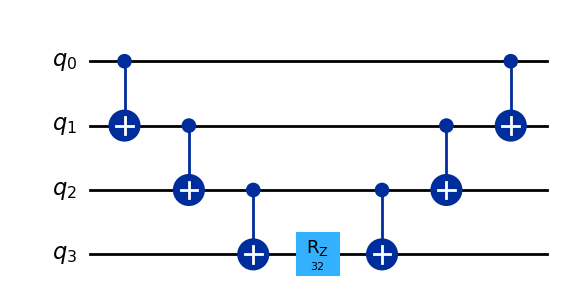

In [6]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer

def puerta_coef(coef,n_vars):
    '''
    Devuelve la puerta cuántica para la digitacización del Hamiltoniano final.

    coef: float | Coeficiente del término que forma parte del Hamiltoniano final.
    n_vars: int | Número de variables (qubits), asociados a dicho término (en nuestro caso será un máximo de 4).
    '''
    circuito = QuantumCircuit(n_vars)
    for ind in range(n_vars-1):
        circuito.cx(ind,ind+1)
    circuito.rz(2*coef,n_vars-1)
    for ind in range(n_vars-1):
        circuito.cx(n_vars-2-ind,n_vars-1-ind)
    # display(circuito.draw("mpl"))
    return circuito

# Ejemplo
display(puerta_coef(16,4).draw("mpl"))

El mapeo de la puerta se realizará en función de los índices de las variables que se han extraído antes. Por ejemplo, para el primer término de $\hat{H}_f$ tendríamos el mapeo $[0,1,4,5]$, pues necesitamos restarle 1 a los índices para hablar de posiciones de _qubits_. Dibujemos el circuito completo a modo de prueba.

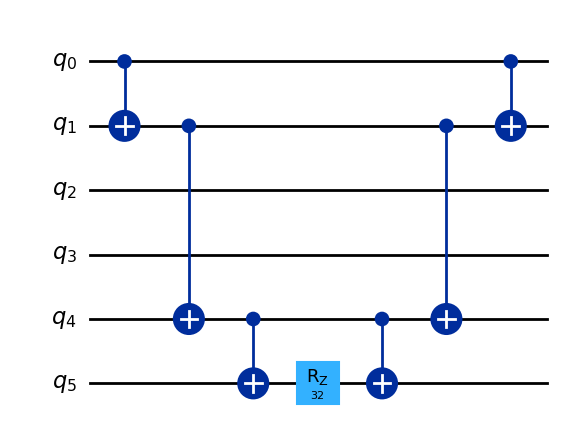

In [7]:
# Construimos el circuito de n_x + n_y qubits
circ_prueba_puerta = QuantumCircuit(nx+ny)

# Añadimos la puerta
circ_prueba_puerta.append(puerta_coef(16,len([1,2,5,6])),[0,1,4,5])

# Dibujamos el circuito
circ_prueba_puerta.decompose().draw("mpl")

A continuación, definimos los parámetros restantes para la digitalización.

In [8]:
T = 10                      # Tiempo final
delta_t = 0.01              # Paso
num_it = int(T/delta_t)     # Número de iteraciones
omega = np.pi/(2*T)

# Schedule en función de la iteración en la que se encuentra la troterización
def lam_t(jt):
    return np.sin(np.pi/2*np.sin(omega*jt)**2)**2

Creamos y simulamos el circuito. Al ser un problema de optimización, podemos prescindir del término independiente, que es el último elemento de la lista $\verb|coef_vars|$.

Tiempo de creación del circuito: 6.591848611831665
Tiempo de simulación: 2.1728451251983643


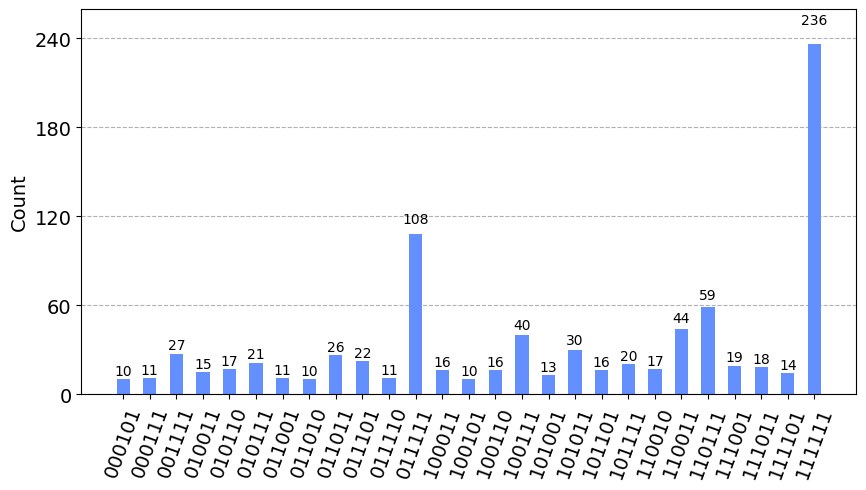

In [8]:
# Circuito para la digitalización
t0 = time()
dig_circuit_qreg = QuantumRegister(nx+ny)
dig_circuit_creg = ClassicalRegister(nx+ny)
dig_circuit = QuantumCircuit(dig_circuit_qreg,dig_circuit_creg)

# Comenzamos con el estado fundamental del Hamiltoniano inicial
dig_circuit.h(dig_circuit_qreg)

# Trotterización
for i in [delta_t*i for i in range(1,num_it+1)]:
    dig_circuit.rx(2*(1-lam_t(i))*(-1)*delta_t,dig_circuit_qreg)                                                    # Factor -1 debido al coeficiente del Hamiltoniano inicial
    for coef, vars in coef_vars[:-1]:                                                                               # No tomamos el término independiente del Hamiltoniano
        dig_circuit.append(puerta_coef(int(coef)*lam_t(i)*delta_t,len(vars)),[dig_circuit_qreg[i-1] for i in vars])

# Mediciones
dig_circuit.measure(dig_circuit_qreg,dig_circuit_creg)
t1 = time()-t0
print("Tiempo de creación del circuito:",t1)

# Simulación en qasm_simulator
dig_circuit = dig_circuit.decompose()                   # Para evitar tiempo de transpilado tomamos el circuito descompuesto
t0 = time()
backend = Aer.get_backend("qasm_simulator")
result = backend.run(dig_circuit,shots=1000).result()
t1 = time()-t0
print("Tiempo de simulación:",t1)

# Mostramos los resultados que superan un 1% de los shots realizados
filt_counts = {k:v for k,v in result.get_counts().items() if v >= 1000*0.01}
display(plot_histogram(filt_counts,figsize=(10,5)))

In [10]:
# Imprimimos el número de puertas y la profundidad del circuito
print("Las puertas necesarias para la implementación son:\n")
print("Tipo de puerta --- Número")
for k, v in dig_circuit.count_ops().items():
    print(f"{k:<18} {v}")
print(f"\nEl circuito tiene un total de {sum(dig_circuit.count_ops().values())} puertas.")
print(f"El circuito tiene una profundidad de {dig_circuit.depth()}.")

Las puertas necesarias para la implementación son:

Tipo de puerta --- Número
cx                 130000
rz                 43000
r                  6000
u2                 6
measure            6

El circuito tiene un total de 179012 puertas.
El circuito tiene una profundidad de 163003.


Con el siguiente código se puede averiguar si el estado más frecuente de la simulación anterior es aquel que factoriza $N$. En este caso, estaríamos hablando de $\left|111111\right>$, con poco más de un $20\%$ de probabilidad de aparecer.

In [11]:
mejor_resultado = max(filt_counts,key=filt_counts.get)
x = 2*int(mejor_resultado[0:nx],2) + 1
y = 2*int(mejor_resultado[-1:nx-1:-1],2) + 1
if N == x*y:
    print(f"Factorización correcta. {N} = {x}*{y}.")
else:
    print(f"Factorización incorrecta. {N} != {x}*{y}.")

Factorización correcta. 217 = 7*31.


Con el fin de comparar con la sección siguiente, digitalicemos ahora el Hamiltoniano resultante de querer factorizar $N = 7\cdot 13$ sin asumir conocidas las longitudes de los factores. La implementación es análoga a la anterior.

In [11]:
# Parámetros iniciales
N = 7*13
ident = sp.symbols("I")  # Símbolo representando la matriz identidad

# Cálculo de qubits. No sabemos las longitudes de los factores, por
# lo que calculamos el número de qubits con lo visto en la teoría
if np.floor(np.sqrt(N)) % 2:  # Parte entera impar
    nx = int(np.ceil(np.log2(np.floor(np.sqrt(N)))) - 1)
else:
    nx = int(np.ceil(np.log2(np.floor(np.sqrt(N) - 1))) - 1)

ny = int(np.ceil(np.log2(np.floor(N / 3))) - 1)

# Valores de n_x y de n_y
print(f"Se tiene que n_x = {nx} y n_y = {ny}.\n")

# Definición de x e y usando Sum
l = sp.symbols('l', integer=True)
m = sp.symbols('m', integer=True)
sigma_z_l = sp.IndexedBase('σ^z')[l]
sigma_z_m = sp.IndexedBase('σ^z')[m]

x = sp.Sum(2**(l-ny) * (ident - sigma_z_l) / 2, (l, ny+1, nx+ny)).doit() + ident
y = sp.Sum(2**(m) * (ident - sigma_z_m) / 2, (m, 1, ny)).doit() + ident

# Expresiones de x e y
# print(x)
# print(y)

# Definición del Hamiltoniano según la proposición 3.1.5
Hamiltoniano = (N * ident - x * y) ** 2

# Expandimos y simplificamos el Hamiltoniano con las propiedades de las matrices de Pauli
# Expansión del Hamiltoniano simplificando la identidad
Hamiltoniano_expand = sp.expand(Hamiltoniano.subs(ident, 1))

# Definimos el Hamiltoniano que buscábamos
Hamiltoniano_simplificado = reemp_potencia(Hamiltoniano_expand)
print("Hamiltoniano final:\n",Hamiltoniano_simplificado)

# Extracción de coeficientes y variables
coef_vars = coeficiente_variable(Hamiltoniano_simplificado)

Se tiene que n_x = 3 y n_y = 4.

Hamiltoniano final:
 16*σ^z[1]*σ^z[2]*σ^z[5]*σ^z[6] + 32*σ^z[1]*σ^z[2]*σ^z[5]*σ^z[7] - 64*σ^z[1]*σ^z[2]*σ^z[5] + 64*σ^z[1]*σ^z[2]*σ^z[6]*σ^z[7] - 128*σ^z[1]*σ^z[2]*σ^z[6] - 256*σ^z[1]*σ^z[2]*σ^z[7] + 340*σ^z[1]*σ^z[2] + 32*σ^z[1]*σ^z[3]*σ^z[5]*σ^z[6] + 64*σ^z[1]*σ^z[3]*σ^z[5]*σ^z[7] - 128*σ^z[1]*σ^z[3]*σ^z[5] + 128*σ^z[1]*σ^z[3]*σ^z[6]*σ^z[7] - 256*σ^z[1]*σ^z[3]*σ^z[6] - 512*σ^z[1]*σ^z[3]*σ^z[7] + 680*σ^z[1]*σ^z[3] + 64*σ^z[1]*σ^z[4]*σ^z[5]*σ^z[6] + 128*σ^z[1]*σ^z[4]*σ^z[5]*σ^z[7] - 256*σ^z[1]*σ^z[4]*σ^z[5] + 256*σ^z[1]*σ^z[4]*σ^z[6]*σ^z[7] - 512*σ^z[1]*σ^z[4]*σ^z[6] - 1024*σ^z[1]*σ^z[4]*σ^z[7] + 1360*σ^z[1]*σ^z[4] - 128*σ^z[1]*σ^z[5]*σ^z[6] - 256*σ^z[1]*σ^z[5]*σ^z[7] + 330*σ^z[1]*σ^z[5] - 512*σ^z[1]*σ^z[6]*σ^z[7] + 660*σ^z[1]*σ^z[6] + 1320*σ^z[1]*σ^z[7] - 1264*σ^z[1] + 64*σ^z[2]*σ^z[3]*σ^z[5]*σ^z[6] + 128*σ^z[2]*σ^z[3]*σ^z[5]*σ^z[7] - 256*σ^z[2]*σ^z[3]*σ^z[5] + 256*σ^z[2]*σ^z[3]*σ^z[6]*σ^z[7] - 512*σ^z[2]*σ^z[3]*σ^z[6] - 1024*σ^z[2]*σ^z[3]*σ^z[7] + 136

Tiempo de creación del circuito: 153.3989601135254
Tiempo de simulación: 52.54386925697327


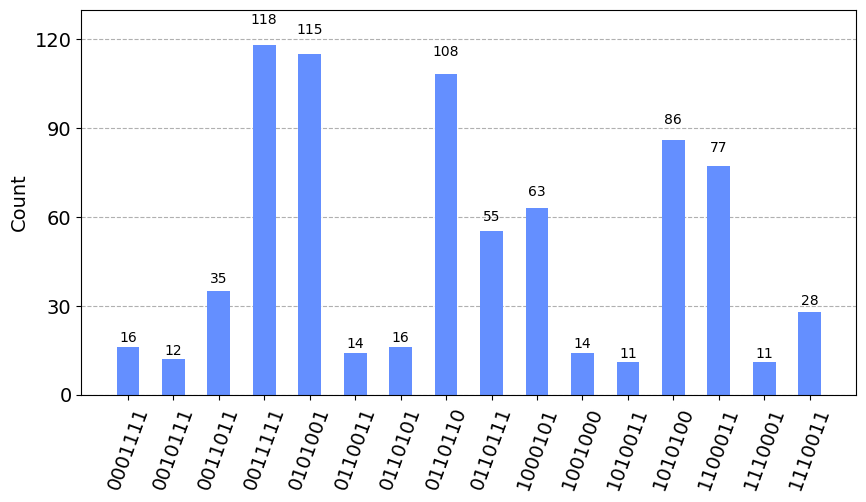

In [18]:
T = 10                      # Tiempo final
delta_t = 0.001             # Paso
num_it = int(T/delta_t)     # Número de iteraciones
omega = np.pi/(2*T)

# Circuito para la digitalización
t0 = time()
dig_circuit_qreg = QuantumRegister(nx+ny)
dig_circuit_creg = ClassicalRegister(nx+ny)
dig_circuit = QuantumCircuit(dig_circuit_qreg,dig_circuit_creg)

# Comenzamos con el estado fundamental del Hamiltoniano inicial
dig_circuit.h(dig_circuit_qreg)

# Trotterización
for i in [delta_t*i for i in range(1,num_it+1)]:
    dig_circuit.rx(2*(1-lam_t(i))*(-1)*delta_t,dig_circuit_qreg)                                                    # Factor -1 debido al coeficiente del Hamiltoniano inicial
    for coef, vars in coef_vars[0:-1]:                                                                              # No tomamos el término independiente del Hamiltoniano
        dig_circuit.append(puerta_coef(int(coef)*lam_t(i)*delta_t,len(vars)),[dig_circuit_qreg[i-1] for i in vars])

# Mediciones
dig_circuit.measure(dig_circuit_qreg,dig_circuit_creg)
t1 = time()-t0
print("Tiempo de creación del circuito:",t1)

# Simulación en qasm_simulator
dig_circuit = dig_circuit.decompose()                   # Para evitar tiempo de transpilado tomamos el circuito descompuesto
t0 = time()
backend = Aer.get_backend("qasm_simulator")
result = backend.run(dig_circuit,shots=1000).result()
t1 = time()-t0
print("Tiempo de simulación:",t1)

# Mostramos los resultados que superan un 1% de los shots realizados
filt_counts = {k:v for k,v in result.get_counts().items() if v >= 1000*0.01}
display(plot_histogram(filt_counts,figsize=(10,5)))

In [20]:
# Imprimimos el número de puertas y la profundidad del circuito
print("Las puertas necesarias para la implementación son:\n")
print("Tipo de puerta --- Número")
for k, v in dig_circuit.count_ops().items():
    print(f"{k:<18} {v}")
print(f"\nEl circuito tiene un total de {sum(dig_circuit.count_ops().values())} puertas.")
print(f"El circuito tiene una profundidad de {dig_circuit.depth()}.")

Las puertas necesarias para la implementación son:

Tipo de puerta --- Número
cx                 2700000
rz                 760000
r                  70000
u2                 7
measure            7

El circuito tiene un total de 3530014 puertas.
El circuito tiene una profundidad de 3220004.


In [21]:
mejor_resultado = max(filt_counts,key=filt_counts.get)
x = 2*int(mejor_resultado[0:nx],2) + 1
y = 2*int(mejor_resultado[-1:nx-1:-1],2) + 1
if N == x*y:
    print(f"Factorización correcta. {N} = {x}*{y}.")
else:
    print(f"Factorización incorrecta. {N} != {x}*{y}.")

Factorización incorrecta. 91 != 3*31.


No se ha obtenido el estado esperado: $\left|0110110\right>$.

### Cambio de _schedule_

Para mejorar la situación anterior, nos hemos tomado la libertad de escoger un _schedule_ distinto al propuesto en el artículo referenciado. Este es: $\lambda(t) = \sin^2\left(\frac{\pi}{2\sin\left(\pi/16\right)}\sin^2\left(\frac{\pi t}{16T}\right)\right)$. Veamos en los dos ejemplos anteriores cómo afecta este cambio a los resultados. Primero estudiaremos el caso $N = 7\cdot 31$.

In [ ]:
# Schedule en función de la iteración en la que se encuentra la troterización
def lam_t(jt):
    return np.sin(np.pi/(2*np.sin(np.pi/16))*np.sin(omega*jt)**2)**2

In [ ]:
# Parámetros iniciales
N = 7*31
ident = sp.symbols("I")  # Símbolo representando la matriz identidad

# Número de qubits. Asumimos longitudes de factores conocidas
nx = 2
ny = 4

# Definición de x e y usando Sum
l = sp.symbols('l', integer=True)
m = sp.symbols('m', integer=True)
sigma_z_l = sp.IndexedBase('σ^z')[l]
sigma_z_m = sp.IndexedBase('σ^z')[m]

x = sp.Sum(2**(l-ny) * (ident - sigma_z_l) / 2, (l, ny+1, nx+ny)).doit() + ident
y = sp.Sum(2**(m) * (ident - sigma_z_m) / 2, (m, 1, ny)).doit() + ident

# Expresiones de x e y
# print(x)
# print(y)

# Definición del Hamiltoniano según la proposición 3.1.5
Hamiltoniano = (N * ident - x * y) ** 2

# Expandimos y simplificamos el Hamiltoniano con las propiedades de las matrices de Pauli
# Expansión del Hamiltoniano simplificando la identidad
Hamiltoniano_expand = sp.expand(Hamiltoniano.subs(ident, 1))

# Definimos el Hamiltoniano que buscábamos
Hamiltoniano_simplificado = reemp_potencia(Hamiltoniano_expand)
print("Hamiltoniano final:\n",Hamiltoniano_simplificado)

# Extracción de coeficientes y variables
coef_vars = coeficiente_variable(Hamiltoniano_simplificado)

Hamiltoniano final:
 16*σ^z[1]*σ^z[2]*σ^z[5]*σ^z[6] - 32*σ^z[1]*σ^z[2]*σ^z[5] - 64*σ^z[1]*σ^z[2]*σ^z[6] + 84*σ^z[1]*σ^z[2] + 32*σ^z[1]*σ^z[3]*σ^z[5]*σ^z[6] - 64*σ^z[1]*σ^z[3]*σ^z[5] - 128*σ^z[1]*σ^z[3]*σ^z[6] + 168*σ^z[1]*σ^z[3] + 64*σ^z[1]*σ^z[4]*σ^z[5]*σ^z[6] - 128*σ^z[1]*σ^z[4]*σ^z[5] - 256*σ^z[1]*σ^z[4]*σ^z[6] + 336*σ^z[1]*σ^z[4] - 128*σ^z[1]*σ^z[5]*σ^z[6] - 178*σ^z[1]*σ^z[5] - 356*σ^z[1]*σ^z[6] + 1064*σ^z[1] + 64*σ^z[2]*σ^z[3]*σ^z[5]*σ^z[6] - 128*σ^z[2]*σ^z[3]*σ^z[5] - 256*σ^z[2]*σ^z[3]*σ^z[6] + 336*σ^z[2]*σ^z[3] + 128*σ^z[2]*σ^z[4]*σ^z[5]*σ^z[6] - 256*σ^z[2]*σ^z[4]*σ^z[5] - 512*σ^z[2]*σ^z[4]*σ^z[6] + 672*σ^z[2]*σ^z[4] - 256*σ^z[2]*σ^z[5]*σ^z[6] - 356*σ^z[2]*σ^z[5] - 712*σ^z[2]*σ^z[6] + 2128*σ^z[2] + 256*σ^z[3]*σ^z[4]*σ^z[5]*σ^z[6] - 512*σ^z[3]*σ^z[4]*σ^z[5] - 1024*σ^z[3]*σ^z[4]*σ^z[6] + 1344*σ^z[3]*σ^z[4] - 512*σ^z[3]*σ^z[5]*σ^z[6] - 712*σ^z[3]*σ^z[5] - 1424*σ^z[3]*σ^z[6] + 4256*σ^z[3] - 1024*σ^z[4]*σ^z[5]*σ^z[6] - 1424*σ^z[4]*σ^z[5] - 2848*σ^z[4]*σ^z[6] + 8512*σ^z[4] + 1364*σ^z[

Tiempo de creación del circuito: 6.767929553985596
Tiempo de simulación: 2.7024924755096436


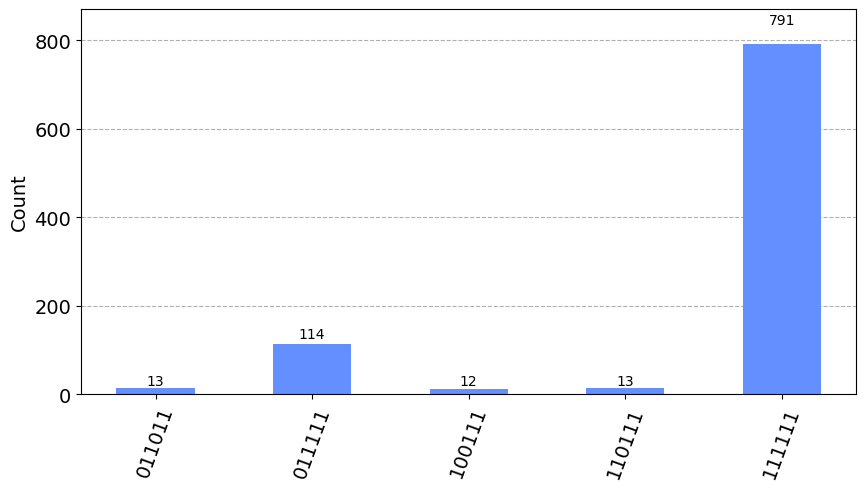

In [ ]:
T = 10                      # Tiempo final
delta_t = 0.01              # Paso
num_it = int(T/delta_t)     # Número de iteraciones
omega = np.pi/(16*T)

# Circuito para la digitalización
t0 = time()
dig_circuit_qreg = QuantumRegister(nx+ny)
dig_circuit_creg = ClassicalRegister(nx+ny)
dig_circuit = QuantumCircuit(dig_circuit_qreg,dig_circuit_creg)

# Comenzamos con el estado fundamental del Hamiltoniano inicial
dig_circuit.h(dig_circuit_qreg)

# Trotterización
for i in [delta_t*i for i in range(1,num_it+1)]:
    dig_circuit.rx(2*(1-lam_t(i))*(-1)*delta_t,dig_circuit_qreg)                                                    # Factor -1 debido al coeficiente del Hamiltoniano inicial
    for coef, vars in coef_vars[:-1]:                                                                               # No tomamos el término independiente del Hamiltoniano
        dig_circuit.append(puerta_coef(int(coef)*lam_t(i)*delta_t,len(vars)),[dig_circuit_qreg[j-1] for j in vars])

# Mediciones
dig_circuit.measure(dig_circuit_qreg,dig_circuit_creg)
t1 = time()-t0
print("Tiempo de creación del circuito:",t1)

# Simulación en qasm_simulator
dig_circuit = dig_circuit.decompose()                   # Para evitar tiempo de transpilado tomamos el circuito descompuesto
t0 = time()
backend = Aer.get_backend("qasm_simulator")
result = backend.run(dig_circuit,shots=1000).result()
t1 = time()-t0
print("Tiempo de simulación:",t1)

# Mostramos los resultados que superan un 1% de los shots realizados
filt_counts = {k:v for k,v in result.get_counts().items() if v >= 1000*0.01}
display(plot_histogram(filt_counts,figsize=(10,5)))

In [ ]:
mejor_resultado = max(filt_counts,key=filt_counts.get)
x = 2*int(mejor_resultado[0:nx],2) + 1
y = 2*int(mejor_resultado[-1:nx-1:-1],2) + 1
if N == x*y:
    print(f"Factorización correcta. {N} = {x}*{y}.")
else:
    print(f"Factorización incorrecta. {N} != {x}*{y}.")

Factorización correcta. 217 = 7*31.


Obtenemos la solución con casi un $79\%$ de probabilidad. Veamos el caso $N=7\cdot13$.

In [ ]:
# Parámetros iniciales
N = 7*13
ident = sp.symbols("I")  # Símbolo representando la matriz identidad

# Cálculo de qubits. No sabemos las longitudes de los factores, por
# lo que calculamos el número de qubits con lo visto en la teoría
if np.floor(np.sqrt(N)) % 2:  # Parte entera impar
    nx = int(np.ceil(np.log2(np.floor(np.sqrt(N)))) - 1)
else:
    nx = int(np.ceil(np.log2(np.floor(np.sqrt(N) - 1))) - 1)

ny = int(np.ceil(np.log2(np.floor(N / 3))) - 1)

# Valores de n_x y de n_y
print(f"Se tiene que n_x = {nx} y n_y = {ny}.\n")

# Definición de x e y usando Sum
l = sp.symbols('l', integer=True)
m = sp.symbols('m', integer=True)
sigma_z_l = sp.IndexedBase('σ^z')[l]
sigma_z_m = sp.IndexedBase('σ^z')[m]

x = sp.Sum(2**(l-ny) * (ident - sigma_z_l) / 2, (l, ny+1, nx+ny)).doit() + ident
y = sp.Sum(2**(m) * (ident - sigma_z_m) / 2, (m, 1, ny)).doit() + ident

# Expresiones de x e y
# print(x)
# print(y)

# Definición del Hamiltoniano según la proposición 3.1.5
Hamiltoniano = (N * ident - x * y) ** 2

# Expandimos y simplificamos el Hamiltoniano con las propiedades de las matrices de Pauli
# Expansión del Hamiltoniano simplificando la identidad
Hamiltoniano_expand = sp.expand(Hamiltoniano.subs(ident, 1))

# Definimos el Hamiltoniano que buscábamos
Hamiltoniano_simplificado = reemp_potencia(Hamiltoniano_expand)
print("Hamiltoniano final:\n",Hamiltoniano_simplificado)

# Extracción de coeficientes y variables
coef_vars = coeficiente_variable(Hamiltoniano_simplificado)

Se tiene que n_x = 3 y n_y = 4.

Hamiltoniano final:
 16*σ^z[1]*σ^z[2]*σ^z[5]*σ^z[6] + 32*σ^z[1]*σ^z[2]*σ^z[5]*σ^z[7] - 64*σ^z[1]*σ^z[2]*σ^z[5] + 64*σ^z[1]*σ^z[2]*σ^z[6]*σ^z[7] - 128*σ^z[1]*σ^z[2]*σ^z[6] - 256*σ^z[1]*σ^z[2]*σ^z[7] + 340*σ^z[1]*σ^z[2] + 32*σ^z[1]*σ^z[3]*σ^z[5]*σ^z[6] + 64*σ^z[1]*σ^z[3]*σ^z[5]*σ^z[7] - 128*σ^z[1]*σ^z[3]*σ^z[5] + 128*σ^z[1]*σ^z[3]*σ^z[6]*σ^z[7] - 256*σ^z[1]*σ^z[3]*σ^z[6] - 512*σ^z[1]*σ^z[3]*σ^z[7] + 680*σ^z[1]*σ^z[3] + 64*σ^z[1]*σ^z[4]*σ^z[5]*σ^z[6] + 128*σ^z[1]*σ^z[4]*σ^z[5]*σ^z[7] - 256*σ^z[1]*σ^z[4]*σ^z[5] + 256*σ^z[1]*σ^z[4]*σ^z[6]*σ^z[7] - 512*σ^z[1]*σ^z[4]*σ^z[6] - 1024*σ^z[1]*σ^z[4]*σ^z[7] + 1360*σ^z[1]*σ^z[4] - 128*σ^z[1]*σ^z[5]*σ^z[6] - 256*σ^z[1]*σ^z[5]*σ^z[7] + 330*σ^z[1]*σ^z[5] - 512*σ^z[1]*σ^z[6]*σ^z[7] + 660*σ^z[1]*σ^z[6] + 1320*σ^z[1]*σ^z[7] - 1264*σ^z[1] + 64*σ^z[2]*σ^z[3]*σ^z[5]*σ^z[6] + 128*σ^z[2]*σ^z[3]*σ^z[5]*σ^z[7] - 256*σ^z[2]*σ^z[3]*σ^z[5] + 256*σ^z[2]*σ^z[3]*σ^z[6]*σ^z[7] - 512*σ^z[2]*σ^z[3]*σ^z[6] - 1024*σ^z[2]*σ^z[3]*σ^z[7] + 136

Tiempo de creación del circuito: 157.80261421203613
Tiempo de simulación: 46.53343462944031


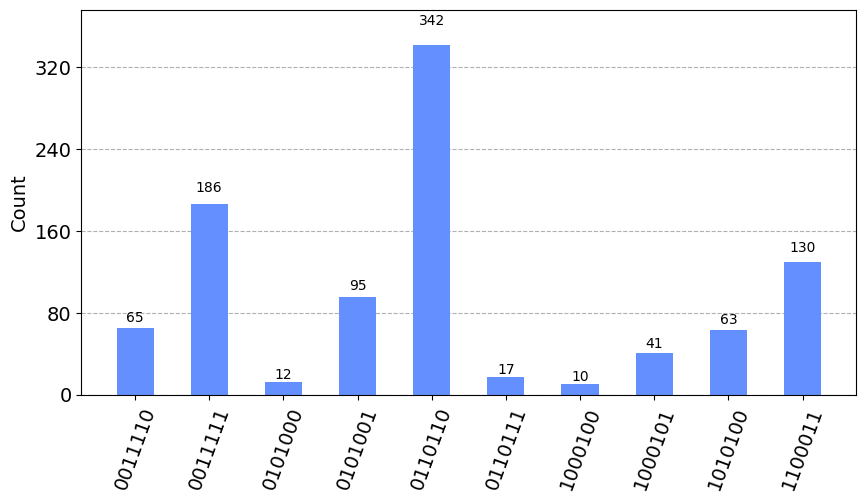

In [ ]:
T = 10                      # Tiempo final
delta_t = 0.001             # Paso
num_it = int(T/delta_t)     # Número de iteraciones
omega = np.pi/(16*T)

# Circuito para la digitalización
t0 = time()
dig_circuit_qreg = QuantumRegister(nx+ny)
dig_circuit_creg = ClassicalRegister(nx+ny)
dig_circuit = QuantumCircuit(dig_circuit_qreg,dig_circuit_creg)

# Comenzamos con el estado fundamental del Hamiltoniano inicial
dig_circuit.h(dig_circuit_qreg)

# Trotterización
for i in [delta_t*i for i in range(1,num_it+1)]:
    dig_circuit.rx(2*(1-lam_t(i))*(-1)*delta_t,dig_circuit_qreg)                                                    # Factor -1 debido al coeficiente del Hamiltoniano inicial
    for coef, vars in coef_vars[:-1]:                                                                               # No tomamos el término independiente del Hamiltoniano
        dig_circuit.append(puerta_coef(int(coef)*lam_t(i)*delta_t,len(vars)),[dig_circuit_qreg[i-1] for i in vars])

# Mediciones
dig_circuit.measure(dig_circuit_qreg,dig_circuit_creg)
t1 = time()-t0
print("Tiempo de creación del circuito:",t1)

# Simulación en qasm_simulator
dig_circuit = dig_circuit.decompose()                   # Para evitar tiempo de transpilado tomamos el circuito descompuesto
t0 = time()
backend = Aer.get_backend("qasm_simulator")
result = backend.run(dig_circuit,shots=1000).result()
t1 = time()-t0
print("Tiempo de simulación:",t1)

# Mostramos los resultados que superan un 1% de los shots realizados
filt_counts = {k:v for k,v in result.get_counts().items() if v >= 1000*0.01}
display(plot_histogram(filt_counts,figsize=(10,5)))

In [ ]:
mejor_resultado = max(filt_counts,key=filt_counts.get)
x = 2*int(mejor_resultado[0:nx],2) + 1
y = 2*int(mejor_resultado[-1:nx-1:-1],2) + 1
if N == x*y:
    print(f"Factorización correcta. {N} = {x}*{y}.")
else:
    print(f"Factorización incorrecta. {N} != {x}*{y}.")

Factorización correcta. 91 = 7*13.


Con el cambio de $\lambda(t)$ se consigue factorizar el entero con una probabilidad de aproximadamente el $34\%$.